For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [6]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

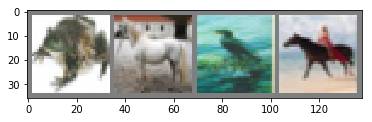

 frog horse  bird horse


In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Define a Convolutional Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [10]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# check device for model
next(net.parameters()).is_cuda

False

#### Define a Loss function and optimizer

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Train the network

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.294
[1,  4000] loss: 1.978
[1,  6000] loss: 1.721
[1,  8000] loss: 1.608
[1, 10000] loss: 1.536
[1, 12000] loss: 1.469
[2,  2000] loss: 1.401
[2,  4000] loss: 1.371
[2,  6000] loss: 1.352
[2,  8000] loss: 1.320
[2, 10000] loss: 1.273
[2, 12000] loss: 1.274
Finished Training


In [14]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Test the network on the test data

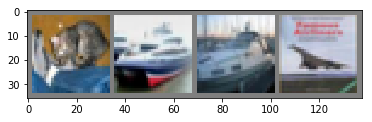

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car  frog   dog  ship


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 68 %
Accuracy of  bird : 42 %
Accuracy of   cat : 24 %
Accuracy of  deer : 54 %
Accuracy of   dog : 44 %
Accuracy of  frog : 71 %
Accuracy of horse : 62 %
Accuracy of  ship : 80 %
Accuracy of truck : 63 %


#### Training on GPU

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [22]:
net.to(device)

In [ ]:
# check device for model
next(net.parameters()).is_cuda

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [23]:
inputs, labels = data[0].to(device), data[1].to(device)

In [24]:
# Same thing goes to the downstream functions that depend on the parameters

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.198
[1,  4000] loss: 1.205
[1,  6000] loss: 1.210
[1,  8000] loss: 1.192
[1, 10000] loss: 1.170
[1, 12000] loss: 1.166
[2,  2000] loss: 1.070
[2,  4000] loss: 1.095
[2,  6000] loss: 1.097
[2,  8000] loss: 1.108
[2, 10000] loss: 1.070
[2, 12000] loss: 1.080
[3,  2000] loss: 0.985
[3,  4000] loss: 1.002
[3,  6000] loss: 1.015
[3,  8000] loss: 1.029
[3, 10000] loss: 1.033
[3, 12000] loss: 1.027
[4,  2000] loss: 0.948
[4,  4000] loss: 0.936
[4,  6000] loss: 0.963
[4,  8000] loss: 0.967
[4, 10000] loss: 0.970
[4, 12000] loss: 0.987
[5,  2000] loss: 0.869
[5,  4000] loss: 0.888
[5,  6000] loss: 0.915
[5,  8000] loss: 0.939
[5, 10000] loss: 0.954
[5, 12000] loss: 0.929
[6,  2000] loss: 0.827
[6,  4000] loss: 0.865
[6,  6000] loss: 0.893
[6,  8000] loss: 0.870
[6, 10000] loss: 0.906
[6, 12000] loss: 0.881
[7,  2000] loss: 0.813
[7,  4000] loss: 0.806
[7,  6000] loss: 0.836
[7,  8000] loss: 0.871
[7, 10000] loss: 0.843
[7, 12000] loss: 0.861
[8,  2000] loss: 0.754
[8,  4000] 